In [1]:
from mcmc import mcmc_run, slab_energy

from ase.calculators.lammpsrun import LAMMPS
from ase.io import read
from ase.build import make_supercell
from catkit.gen.adsorption import get_adsorption_sites

import catkit
import os
import numpy as np

import sys
sys.path.append("/home/dux/")
from htvs.djangochem.pgmols.utils import surfaces

In [2]:
# Get pristine surface
# GaN 0001 surface
atoms = read('GaN_hexagonal.cif')

# supercell_atoms = atoms*(2,2,2)
# supercell_atoms.write('GaN_hexagonal_2x2.cif')

supercell_atoms = atoms*(3,3,3)
supercell_atoms.write('GaN_hexagonal_3x3.cif')

# might do the opposite layer [0,0,0,1] when the stated layer in ref is [0,0,0,-1]
slab, surface_atoms = surfaces.surface_from_bulk(supercell_atoms, [0,0,0,-1], size=[3,3], vacuum=10)

# set surface atoms from the other side
all_atoms = np.arange(len(slab))
curr_surf_atoms = slab.get_surface_atoms()
new_surf_atoms = np.setdiff1d(all_atoms, curr_surf_atoms)
slab.set_surface_atoms(new_surf_atoms)
# invert the positions
slab.set_scaled_positions(1 - slab.get_scaled_positions())

# slab.write('GaN_0001_2x2_pristine_slab.cif')
slab.write('GaN_0001_3x3_pristine_slab.cif')

/home/dux/.local/lib/python3.9/site-packages/catkit/gen/surface.py:334: UserWarning: Your slab has no bulk atoms and may be too thin to identify surface atoms correctly. This may cause surface adsorption site identification to fail.
  warnings.warn(


In [3]:
# try 2003 tersoff potential 
parameters = {
    'pair_style': 'tersoff',
    'pair_coeff': ['* * GaN.tersoff Ga N']
}
potential_file = os.path.join(os.environ["LAMMPS_POTENTIALS"], 'GaN.sw')
lammps_calc = LAMMPS(files=[potential_file], keep_tmp_files=False, keep_alive=False, tmp_dir="/home/dux/surface_sampling/tmp_files")
lammps_calc.set(**parameters)

{'pair_style': 'tersoff', 'pair_coeff': ['* * GaN.tersoff Ga N']}

In [4]:
element = 'Ga'
ads = catkit.gratoms.Gratoms(element)

In [7]:
def start_iter(slab, stat_len, output_template, start_iter=0, max_iter = 10, alpha=1e-3):
    curr_iter = start_iter
    while curr_iter < max_iter:
        print(f"curr slab energy {slab_energy(slab)}")
        all_forces = slab.get_forces()
        # print(f"max force {np.max(np.abs(all_forces))}")
        rel_forces = all_forces[stat_len:]
        all_pos = slab.get_positions()
        rel_pos = all_pos[stat_len:]
        rel_pos += alpha*rel_forces
        all_pos[stat_len:] = rel_pos
        slab.set_positions(all_pos)
        curr_iter += 1
        slab.write(output_template.format(curr_iter))

In [8]:
# starting from more random initial positions
num_ads_atoms = 12 # needs to have so many atoms

slab, surface_atoms = surfaces.surface_from_bulk(supercell_atoms, [0,0,0,-1], size=[3,3], vacuum=10)
# get initial adsorption sites
proper_adsorbed = read("GaN_0001_3x3_12_Ga_ads_initial_slab.cif")
ads_positions = proper_adsorbed.get_positions()[len(slab):]
assert len(ads_positions) == num_ads_atoms, "num of adsorption sites does not match num ads atoms"

curr_iter = 0
max_iter = 10

proper_adsorbed.calc = lammps_calc
stat_len = len(slab)

start_iter(proper_adsorbed, stat_len, output_template="GaN_0001_3x3_12_Ga_ads_iter{:02d}_slab.cif", max_iter=max_iter)

curr slab energy -135.0109465609059
curr slab energy -135.777842158621
curr slab energy -136.5656120202012
curr slab energy -137.380820013302
curr slab energy -138.2297848189095
curr slab energy -139.1181249079737
curr slab energy -140.0501204409404
curr slab energy -141.0298881821362
curr slab energy -142.0687360864553
curr slab energy -143.1717323778874


In [9]:
# manually get the atoms into *correct* positions
# proper_adsorbed.get_positions()
arranged_slab = read("GaN_0001_3x3_12_Ga_ads_arranged_slab.cif")
arranged_slab.calc = lammps_calc

slab_energy(arranged_slab)

-174.1774576888822

In [10]:
from ase.optimize import BFGS
from ase.constraints import FixAtoms

num_bulk_atoms = len(slab)
bulk_indices = list(range(num_bulk_atoms))
print(f"bulk indices {bulk_indices}")
c = FixAtoms(indices=bulk_indices)
arranged_slab.set_constraint(c)

# make bulk atoms don't move
copied_slab = arranged_slab.copy()
copied_slab.calc = lammps_calc

dyn = BFGS(copied_slab)
dyn.run(fmax=0.05)
BFGS_optim_file = "GaN_0001_3x3_12_Ga_ads_BFGS_optim_arranged_slab.cif"
dyn.atoms.write(BFGS_optim_file)

copied_slab.write("GaN_0001_3x3_12_Ga_ads_original_optim_arranged_slab.cif")
# copied slab looks the same, 

bulk indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
      Step     Time          Energy         fmax
BFGS:    0 17:10:21     -174.177458        3.4785
BFGS:    1 17:10:21     -175.981365        4.4040
BFGS:    2 17:10:21     -179.517607        3.9735
BFGS:    3 17:10:21     -179.922619        2.9606
BFGS:    4 17:10:22     -180.483202        0.3381
BFGS:    5 17:10:22     -180.498811        0.2446
BFGS:    6 17:10:22     -180.518476        0.1344
BFGS:    7 17:10:22     -180.519468        0.1245
BFGS:    8 17:10:22     -180.523781        0.0309


In [11]:
optim_slab = read(BFGS_optim_file)
optim_slab.calc = lammps_calc
slab_energy(optim_slab)

-180.5237675050187

In [12]:
# try optimizing the arranged slab
# varying the learning rate
# ensure that movement for each iter isn't so huge
start_iter(arranged_slab, stat_len, output_template="GaN_0001_3x3_12_Ga_ads_iter{:02d}_arranged_slab.cif", max_iter=20, alpha=1e-2)

curr slab energy -174.1774576888822
curr slab energy -175.4000061941359
curr slab energy -177.0837776719654
curr slab energy -178.7684593127665
curr slab energy -179.9587292724641
curr slab energy -180.4046294989771
curr slab energy -180.4516271196324
curr slab energy -180.4726912768402
curr slab energy -180.4868311701726
curr slab energy -180.496638946703
curr slab energy -180.5034918533291
curr slab energy -180.5083192180777
curr slab energy -180.5117571247416
curr slab energy -180.5142402758773
curr slab energy -180.5160649063448
curr slab energy -180.5174324002707
curr slab energy -180.5184794944114
curr slab energy -180.5192990841638
curr slab energy -180.5199544598769
curr slab energy -180.520488981158


In [17]:
# canonical with relaxation
num_runs = 10
surface_name = "GaN_0001_3x3"
alpha = 0.99
slab, surface_atoms = surfaces.surface_from_bulk(supercell_atoms, [0,0,0,-1], size=[3,3], vacuum=10)
# set surface atoms from the other side
all_atoms = np.arange(len(slab))
curr_surf_atoms = slab.get_surface_atoms()
new_surf_atoms = np.setdiff1d(all_atoms, curr_surf_atoms)
slab.set_surface_atoms(new_surf_atoms)
# invert the positions
slab.set_scaled_positions(1 - slab.get_scaled_positions())

# try positive chem pot
chem_pot = 5
history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_runs=num_runs, temp=1, pot=chem_pot, alpha=alpha, slab=slab, calc=lammps_calc, surface_name=surface_name, element=element, canonical=True, num_ads_atoms=num_ads_atoms, relax=True)

INFO:Running with num_runs = 10, temp = 1, pot = 5, alpha = 0.99
INFO:there are 36 atoms 
INFO:using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f5dd38d2160>
INFO:In pristine slab, there are a total of 72 sites


      Step     Time          Energy         fmax
BFGS:    0 17:11:39     -125.024889       45.0516
BFGS:    1 17:11:39     -131.316236       25.0657
BFGS:    2 17:11:39     -135.444030       17.5912
BFGS:    3 17:11:39     -138.408712       13.0288
BFGS:    4 17:11:39     -140.641015        9.3653
BFGS:    5 17:11:39     -141.965697        5.7379
BFGS:    6 17:11:39     -142.862364        5.8737
BFGS:    7 17:11:39     -144.306281        8.3100
BFGS:    8 17:11:39     -145.269430        5.4209
BFGS:    9 17:11:39     -145.531035        4.6217
BFGS:   10 17:11:39     -145.760088        3.8737
BFGS:   11 17:11:39     -145.741233        8.8960
BFGS:   12 17:11:39     -146.107947        4.2645
BFGS:   13 17:11:39     -146.385001        3.1763
BFGS:   14 17:11:39     -146.487872        3.4890
BFGS:   15 17:11:39     -146.584190        1.8794
BFGS:   16 17:11:39     -146.626636        0.5221
BFGS:   17 17:11:39     -146.631461        0.2225
BFGS:   18 17:11:39     -146.634727        0.1246
 

INFO:running for 72 iterations per run over a total of 10 runs
INFO:adsorbate is Ga
INFO:In sweep 1 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:11:54      133.249471      168.9226
BFGS:    1 17:11:54       65.264956       84.8939
BFGS:    2 17:11:54        7.420371       69.6112
BFGS:    3 17:11:54      -34.703185       40.2048
BFGS:    4 17:11:54      -61.062271       25.8778
BFGS:    5 17:11:54      -80.766096       22.5249
BFGS:    6 17:11:54      -94.151655       12.5319
BFGS:    7 17:11:54     -108.380241       14.7958
BFGS:    8 17:11:54     -121.306235       19.9467
BFGS:    9 17:11:54     -132.019707       14.6784
BFGS:   10 17:11:54     -140.346682       11.8508
BFGS:   11 17:11:55     -147.155417        9.8728
BFGS:   12 17:11:55     -151.732724        8.1653
BFGS:   13 17:11:55     -157.250564        7.4812
BFGS:   14 17:11:55     -161.435380       12.5036
BFGS:   15 17:11:55     -164.684693        8.9592
BFGS:   16 17:11:55     -166.946547        6.2325
BFGS:   17 17:11:55     -168.444126        4.8595
BFGS:   18 17:11:55     -169.619340        4.7990
B

INFO:In sweep 2 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:13:04     -124.314669       32.5859
BFGS:    1 17:13:04     -135.119550       18.4988
BFGS:    2 17:13:04     -144.880303        9.2287
BFGS:    3 17:13:04     -152.033384        9.9729
BFGS:    4 17:13:04     -156.124828        7.2444
BFGS:    5 17:13:04     -159.835008       12.5834
BFGS:    6 17:13:04     -163.219868        8.3577
BFGS:    7 17:13:04     -165.010931        5.4758
BFGS:    8 17:13:04     -166.062692        5.9689
BFGS:    9 17:13:04     -167.038045        2.7365
BFGS:   10 17:13:04     -167.604780        2.5956
BFGS:   11 17:13:04     -168.043390        4.9160
BFGS:   12 17:13:05     -168.288883        1.5634
BFGS:   13 17:13:05     -168.392603        1.3015
BFGS:   14 17:13:05     -168.538946        3.4571
BFGS:   15 17:13:05     -168.661699        1.9896
BFGS:   16 17:13:05     -168.741959        0.6946
BFGS:   17 17:13:05     -168.775048        0.7166
BFGS:   18 17:13:05     -168.814692        0.6463
B

INFO:In sweep 3 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:14:13       40.488951       91.9879
BFGS:    1 17:14:13       -0.229906       44.3325
BFGS:    2 17:14:13      -27.552455       37.8609
BFGS:    3 17:14:13      -46.655361       36.5155
BFGS:    4 17:14:13      -62.895256       31.9430
BFGS:    5 17:14:14      -79.500133       32.8185
BFGS:    6 17:14:14      -91.927430       27.4340
BFGS:    7 17:14:14     -101.765594       15.4626
BFGS:    8 17:14:14     -112.239235       17.8086
BFGS:    9 17:14:14     -118.621234        8.0496
BFGS:   10 17:14:14     -125.239545       11.3606
BFGS:   11 17:14:14     -132.065011       11.2547
BFGS:   12 17:14:14     -136.434215       12.7735
BFGS:   13 17:14:14     -141.762844       12.4489
BFGS:   14 17:14:14     -146.685051       12.3961
BFGS:   15 17:14:14     -151.888841       11.9100
BFGS:   16 17:14:14     -156.585246       11.1792
BFGS:   17 17:14:14     -160.621016       13.5320
BFGS:   18 17:14:14     -163.698758        6.8110
B

INFO:In sweep 4 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:15:23       20.371934      133.1333
BFGS:    1 17:15:23      -24.575042       69.5210
BFGS:    2 17:15:23      -54.514881       52.1476
BFGS:    3 17:15:23      -78.047679       32.9967
BFGS:    4 17:15:23      -92.728050       27.5068
BFGS:    5 17:15:23     -105.072881       22.6883
BFGS:    6 17:15:23     -116.479908       22.4132
BFGS:    7 17:15:23     -125.267338       12.8708
BFGS:    8 17:15:23     -131.999939       10.7198
BFGS:    9 17:15:23     -137.757314        5.7441
BFGS:   10 17:15:23     -141.910686        8.0073
BFGS:   11 17:15:23     -147.215557       13.3334
BFGS:   12 17:15:23     -156.210794       15.0082
BFGS:   13 17:15:23     -160.562801       11.9116
BFGS:   14 17:15:23     -165.899205        7.6826
BFGS:   15 17:15:24     -168.699248       11.2020
BFGS:   16 17:15:24     -170.731215        4.5699
BFGS:   17 17:15:24     -172.236722        3.9007
BFGS:   18 17:15:24     -173.418110        3.9328
B

INFO:In sweep 5 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:16:33       -5.937315       99.1092
BFGS:    1 17:16:33      -45.049612       48.4503
BFGS:    2 17:16:33      -75.164649       35.8079
BFGS:    3 17:16:33      -93.741179       25.9231
BFGS:    4 17:16:33     -107.319618       20.7704
BFGS:    5 17:16:33     -118.876427       15.4988
BFGS:    6 17:16:33     -128.316155       10.1809
BFGS:    7 17:16:33     -137.048302       12.7710
BFGS:    8 17:16:33     -145.514935        9.9760
BFGS:    9 17:16:33     -150.843956        7.0775
BFGS:   10 17:16:33     -155.398652        7.8740
BFGS:   11 17:16:33     -159.619364       14.2959
BFGS:   12 17:16:33     -163.849499       14.6073
BFGS:   13 17:16:33     -167.914162        8.6955
BFGS:   14 17:16:34     -170.412945        6.0763
BFGS:   15 17:16:34     -171.451644        5.4719
BFGS:   16 17:16:34     -172.542772        2.9857
BFGS:   17 17:16:34     -172.845367        2.0163
BFGS:   18 17:16:34     -173.347605        4.5443
B

INFO:In sweep 6 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:17:43      -99.041186       22.0331
BFGS:    1 17:17:43     -115.480690       11.9004
BFGS:    2 17:17:43     -127.587443       10.5103
BFGS:    3 17:17:43     -132.940277        7.0617
BFGS:    4 17:17:43     -137.875631        7.0864
BFGS:    5 17:17:43     -142.612837        9.2027
BFGS:    6 17:17:43     -146.457591        8.8012
BFGS:    7 17:17:43     -150.902103       11.5905
BFGS:    8 17:17:43     -155.203458       16.9041
BFGS:    9 17:17:43     -158.527658       12.1404
BFGS:   10 17:17:43     -161.341718       12.6450
BFGS:   11 17:17:43     -162.524603        8.8718
BFGS:   12 17:17:43     -164.344263        7.7270
BFGS:   13 17:17:43     -167.698155        4.8974
BFGS:   14 17:17:43     -169.868195        6.2781
BFGS:   15 17:17:43     -170.776515        3.4025
BFGS:   16 17:17:43     -171.198680        2.3837
BFGS:   17 17:17:43     -172.183824        4.7196
BFGS:   18 17:17:43     -172.071083        4.2147
B

INFO:In sweep 7 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:18:52       93.253688      128.6632
BFGS:    1 17:18:52       19.635110       66.4187
BFGS:    2 17:18:53      -27.458385       65.0860
BFGS:    3 17:18:53      -58.350026       49.5733
BFGS:    4 17:18:53      -82.956398       37.9179
BFGS:    5 17:18:53      -99.013985       35.5003
BFGS:    6 17:18:53     -108.966949       16.1948
BFGS:    7 17:18:53     -118.559601       13.0811
BFGS:    8 17:18:53     -125.838490       15.4471
BFGS:    9 17:18:53     -133.022047       14.0085
BFGS:   10 17:18:53     -138.709773       11.1744
BFGS:   11 17:18:53     -143.636663        4.5914
BFGS:   12 17:18:53     -147.537562        4.3139
BFGS:   13 17:18:53     -151.519044       10.2135
BFGS:   14 17:18:53     -156.224639       11.4358
BFGS:   15 17:18:53     -158.886513        8.0900
BFGS:   16 17:18:53     -162.399755       10.3932
BFGS:   17 17:18:53     -165.602333        9.2207
BFGS:   18 17:18:53     -167.377804        6.1465
B

INFO:In sweep 8 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:20:02      -53.063340      104.4955
BFGS:    1 17:20:02      -84.351327       48.1775
BFGS:    2 17:20:02     -109.850704       27.1512
BFGS:    3 17:20:02     -124.132611       18.6617
BFGS:    4 17:20:02     -133.623735       12.2820
BFGS:    5 17:20:02     -141.843199       11.4826
BFGS:    6 17:20:02     -148.341299       11.4155
BFGS:    7 17:20:02     -151.510606        5.7712
BFGS:    8 17:20:02     -155.651965        9.5992
BFGS:    9 17:20:02     -159.055127        7.4217
BFGS:   10 17:20:02     -163.179951       10.5224
BFGS:   11 17:20:02     -167.243214        4.5827
BFGS:   12 17:20:03     -168.806642        3.1939
BFGS:   13 17:20:03     -169.437232        4.2504
BFGS:   14 17:20:03     -170.629403        4.2270
BFGS:   15 17:20:03     -171.194083        4.6189
BFGS:   16 17:20:03     -171.824729        2.3584
BFGS:   17 17:20:03     -172.060236        2.0557
BFGS:   18 17:20:03     -172.324796        1.8070
B

INFO:In sweep 9 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:21:10      -51.199610      103.7802
BFGS:    1 17:21:10      -84.552040       47.0014
BFGS:    2 17:21:10     -105.377284       32.3249
BFGS:    3 17:21:10     -122.327413       20.9015
BFGS:    4 17:21:10     -133.607684       13.5182
BFGS:    5 17:21:10     -142.157308        9.0092
BFGS:    6 17:21:10     -148.281990       10.2478
BFGS:    7 17:21:10     -153.399295        8.1299
BFGS:    8 17:21:10     -158.819851       12.5735
BFGS:    9 17:21:10     -162.477052        8.5014
BFGS:   10 17:21:10     -165.802780        7.1503
BFGS:   11 17:21:10     -167.921473        5.5641
BFGS:   12 17:21:10     -168.759843        5.2259
BFGS:   13 17:21:10     -170.395971        3.9135
BFGS:   14 17:21:10     -170.737517        2.8666
BFGS:   15 17:21:10     -171.026163        2.3992
BFGS:   16 17:21:10     -171.135264        2.1287
BFGS:   17 17:21:10     -171.272423        1.0611
BFGS:   18 17:21:10     -171.373997        1.6998
B

INFO:In sweep 10 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:21:48      -44.575405       47.8834
BFGS:    1 17:21:48      -73.767237       27.7945
BFGS:    2 17:21:48      -96.327684       20.1805
BFGS:    3 17:21:48     -111.481483       14.3002
BFGS:    4 17:21:48     -122.041761       10.1326
BFGS:    5 17:21:48     -130.025649        9.9020
BFGS:    6 17:21:48     -135.690977        7.4671
BFGS:    7 17:21:48     -143.199323       14.7859
BFGS:    8 17:21:48     -150.860490       14.3586
BFGS:    9 17:21:48     -156.312046        9.0080
BFGS:   10 17:21:48     -162.243595       13.5026
BFGS:   11 17:21:48     -166.181406       12.0050
BFGS:   12 17:21:49     -168.730084        8.3126
BFGS:   13 17:21:49     -171.085793        7.0881
BFGS:   14 17:21:49     -172.860153        4.6105
BFGS:   15 17:21:49     -173.964966        4.1649
BFGS:   16 17:21:49     -174.502625        5.0392
BFGS:   17 17:21:49     -174.967083        3.7320
BFGS:   18 17:21:49     -175.479832        3.8657
B

In [7]:
# grand canonical 
num_runs = 100
# surface_name = "GaN_0001_2x2"
surface_name = "GaN_0001_3x3"
alpha = 0.99
slab, surface_atoms = surfaces.surface_from_bulk(supercell_atoms, [0,0,0,-1], size=[3,3], vacuum=10)
# set surface atoms from the other side
all_atoms = np.arange(len(slab))
curr_surf_atoms = slab.get_surface_atoms()
new_surf_atoms = np.setdiff1d(all_atoms, curr_surf_atoms)
slab.set_surface_atoms(new_surf_atoms)
# invert the positions
slab.set_scaled_positions(1 - slab.get_scaled_positions())

history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_runs=num_runs, temp=1, pot=0, alpha=0.99, slab=slab, calc=lammps_calc, surface_name=surface_name, element=element)

INFO:Running with num_runs = 100, temp = 1, pot = 0, alpha = 0.99
INFO:there are 36 atoms 
INFO:using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f308dd10d60>
INFO:In pristine slab, there are a total of 72 sites
INFO:running for 72 iterations per run over a total of 100 runs
INFO:adsorbate is Ga
INFO:In sweep 1 out of 100
INFO:In sweep 2 out of 100


KeyboardInterrupt: 

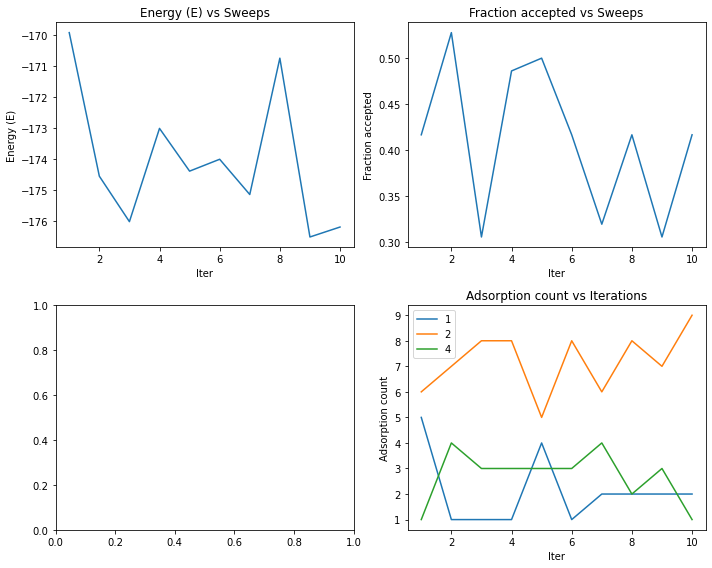

In [18]:
import matplotlib.pyplot as plt
runs = range(1, num_runs+1)

# do the plots
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].plot(runs, energy_hist)
ax[0, 0].set_xlabel("Iter")
ax[0, 0].set_ylabel("Energy (E)")
ax[0, 0].set_title("Energy (E) vs Sweeps")

ax[0, 1].plot(runs, frac_accept_hist)
ax[0, 1].set_xlabel("Iter")
ax[0, 1].set_ylabel("Fraction accepted")
ax[0, 1].set_title("Fraction accepted vs Sweeps")

ax[1, 1].plot(runs, np.array(list(adsorption_count_hist.values())).T)
ax[1, 1].set_xlabel("Iter")
ax[1, 1].set_ylabel("Adsorption count")
ax[1, 1].legend(adsorption_count_hist.keys())
ax[1, 1].set_title("Adsorption count vs Iterations")

fig.show()
fig.tight_layout()

OK, Forget about all of these!! Use a 3x3 unit cell!

In [71]:
# but why not rotate the slab instead
import math
rot_matrix = np.array([
    [math.sqrt(3)/2, -1/2, 0],
    [1/2, math.sqrt(3)/2, 0],
    [0, 0, 1]
    ]) 
rot_slab = make_supercell(slab, rot_matrix, wrap=False, tol=1e-4)
# rot_supercell.write("GaN_hexagonal_rot_sqrt3xsqrt3.cif")
# rot_slab, surface_atoms = surfaces.surface_from_bulk(rot_supercell, [0,0,0,1], size=[4,4], vacuum=10)
# slab.write('GaN_0001_2x2_pristine_slab.cif')
rot_slab.write('GaN_0001_rot_4x4_pristine_slab.cif')

In [88]:
# rotating the unit cell
import math
rot_matrix = np.array([
    [math.sqrt(3)/2, -1/2, 0],
    [1/2, math.sqrt(3)/2, 0],
    [0, 0, 1]
    ]) 
id_matrix = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
    ]) 
int_trans_matrix = np.array([
    [5, 0, 0],
    [0, 5, 0],
    [0, 0, 1]
    ]) 
rot_cell = make_supercell(atoms, rot_matrix, wrap=True, tol=1e-4)
rot_cell.write("GaN_hexagonal_rot_sqrt3xsqrt3.cif")
# manually edit the lattice parameters before loading

rot_cell = read("GaN_hexagonal_rot_sqrt3xsqrt3_lattice_edited.cif")
rot_supercell = rot_cell*(4,4,4)
rot_supercell.write("GaN_hexagonal_rot_sqrt3xsqrt3_4x4.cif")

# manually edit the lattice parameters before loading
# well, no need to manually edit after editing the primitive unit cell
# rot_supercell = read("GaN_hexagonal_rot_sqrt3xsqrt3_4x4_lattice_edited.cif")
rot_slab, surface_atoms = surfaces.surface_from_bulk(rot_supercell, [0,0,0,1], size=[4,4], vacuum=10)
# slab.write('GaN_0001_2x2_pristine_slab.cif')
rot_slab.write('GaN_0001_rot_4x4_pristine_slab.cif')

In [90]:
# rotate the supercell instead
supercell_atoms = atoms*(4,4,4)
supercell_atoms.write('GaN_hexagonal_4x4.cif')

rot_supercell = make_supercell(supercell_atoms, rot_matrix, wrap=True, tol=1e-4)
rot_supercell.write("GaN_hexagonal_rot_from_supcell_sqrt3xsqrt3_4x4.cif")
# manually edit the lattice parameters before loading
rot_supercell = read("GaN_hexagonal_rot_from_supcell_sqrt3xsqrt3_4x4_lattice_edited.cif")
rot_supercell.write("GaN_hexagonal_rot_sqrt3xsqrt3_4x4.cif")

rot_slab, surface_atoms = surfaces.surface_from_bulk(rot_supercell, [0,0,0,1], size=[4,4], vacuum=10)
# slab.write('GaN_0001_2x2_pristine_slab.cif')
rot_slab.write('GaN_0001_rot_4x4_pristine_slab.cif')
# EVEN MORE MESSED UP!

In [9]:
from time import perf_counter

chem_pots = np.linspace(-4, 0, 5)
# chem_pots = [0] # do just one

element = 'Si'
ads = catkit.gratoms.Gratoms(element)

num_runs = 100
all_energy_hist = np.random.rand(len(chem_pots), num_runs)
all_frac_accept_hist = np.random.rand(len(chem_pots), num_runs)
all_top_count_hist = np.random.rand(len(chem_pots), num_runs)
all_bridge_count_hist = np.random.rand(len(chem_pots), num_runs)
all_hollow_count_hist = np.random.rand(len(chem_pots), num_runs)

for i, chem_pot in enumerate(chem_pots):
    start = perf_counter()
    slab, surface_atoms = surfaces.surface_from_bulk(atoms, [1,0,0], size=[4,4])
    history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_runs=num_runs, temp=1, pot=chem_pot, alpha=1, slab=slab, calc=lammps_calc, element=element)
    stop = perf_counter()
    print(f"Time taken = {stop - start} seconds")
    all_energy_hist[i] = energy_hist
    all_frac_accept_hist[i] = frac_accept_hist
    all_top_count_hist[i] = adsorption_count_hist[1]
    all_bridge_count_hist[i] = adsorption_count_hist[2]
    all_hollow_count_hist[i] = adsorption_count_hist[4]

/home/dux/.local/lib/python3.9/site-packages/catkit/gen/surface.py:334: UserWarning: Your slab has no bulk atoms and may be too thin to identify surface atoms correctly. This may cause surface adsorption site identification to fail.
  warnings.warn(
INFO:Running with num_runs = 100, temp = 1, pot = -4.0, alpha = 1
/home/dux/.local/lib/python3.9/site-packages/catkit/gen/adsorption.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r1_topology = np.array(self.r1_topology)
/home/dux/.local/lib/python3.9/site-packages/catkit/gen/adsorption.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specif

there are 64 atoms 
using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f05d3ad3130>


INFO:In pristine slab, there are a total of 128 sites
/home/dux/miniconda3/envs/mlenv/lib/python3.9/site-packages/ase/calculators/lammpsrun.py:379: UserWarning: semi-periodic ASE cell detected - translation to proper LAMMPS input cell might fail
  warnings.warn(
INFO:running for 128 iterations per run over a total of 100 runs
INFO:adsorbate is Si
INFO:In sweep 1 out of 100
INFO:In sweep 2 out of 100
INFO:In sweep 3 out of 100
INFO:In sweep 4 out of 100
INFO:In sweep 5 out of 100
INFO:In sweep 6 out of 100
INFO:In sweep 7 out of 100
INFO:In sweep 8 out of 100
INFO:In sweep 9 out of 100
INFO:In sweep 10 out of 100
INFO:In sweep 11 out of 100
INFO:In sweep 12 out of 100
INFO:In sweep 13 out of 100
INFO:In sweep 14 out of 100
INFO:In sweep 15 out of 100
INFO:In sweep 16 out of 100
INFO:In sweep 17 out of 100
INFO:In sweep 18 out of 100
INFO:In sweep 19 out of 100
INFO:In sweep 20 out of 100
INFO:In sweep 21 out of 100
INFO:In sweep 22 out of 100
INFO:In sweep 23 out of 100
INFO:In sweep 24

Time taken = 154.34343207790516 seconds


INFO:Running with num_runs = 100, temp = 1, pot = -3.0, alpha = 1


there are 64 atoms 
using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f05d3ad3130>


INFO:In pristine slab, there are a total of 128 sites
INFO:running for 128 iterations per run over a total of 100 runs
INFO:adsorbate is Si
INFO:In sweep 1 out of 100
INFO:In sweep 2 out of 100
INFO:In sweep 3 out of 100
INFO:In sweep 4 out of 100
INFO:In sweep 5 out of 100
INFO:In sweep 6 out of 100
INFO:In sweep 7 out of 100
INFO:In sweep 8 out of 100
INFO:In sweep 9 out of 100
INFO:In sweep 10 out of 100
INFO:In sweep 11 out of 100
INFO:In sweep 12 out of 100
INFO:In sweep 13 out of 100
INFO:In sweep 14 out of 100
INFO:In sweep 15 out of 100
INFO:In sweep 16 out of 100
INFO:In sweep 17 out of 100
INFO:In sweep 18 out of 100
INFO:In sweep 19 out of 100
INFO:In sweep 20 out of 100
INFO:In sweep 21 out of 100
INFO:In sweep 22 out of 100
INFO:In sweep 23 out of 100
INFO:In sweep 24 out of 100
INFO:In sweep 25 out of 100
INFO:In sweep 26 out of 100
INFO:In sweep 27 out of 100
INFO:In sweep 28 out of 100
INFO:In sweep 29 out of 100
INFO:In sweep 30 out of 100
INFO:In sweep 31 out of 100
I

Time taken = 157.36120266700163 seconds


INFO:Running with num_runs = 100, temp = 1, pot = -2.0, alpha = 1


there are 64 atoms 
using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f05d3ad3130>


INFO:In pristine slab, there are a total of 128 sites
INFO:running for 128 iterations per run over a total of 100 runs
INFO:adsorbate is Si
INFO:In sweep 1 out of 100
INFO:In sweep 2 out of 100
INFO:In sweep 3 out of 100
INFO:In sweep 4 out of 100
INFO:In sweep 5 out of 100
INFO:In sweep 6 out of 100
INFO:In sweep 7 out of 100
INFO:In sweep 8 out of 100
INFO:In sweep 9 out of 100
INFO:In sweep 10 out of 100
INFO:In sweep 11 out of 100
INFO:In sweep 12 out of 100
INFO:In sweep 13 out of 100
INFO:In sweep 14 out of 100
INFO:In sweep 15 out of 100
INFO:In sweep 16 out of 100
INFO:In sweep 17 out of 100
INFO:In sweep 18 out of 100
INFO:In sweep 19 out of 100
INFO:In sweep 20 out of 100
INFO:In sweep 21 out of 100
INFO:In sweep 22 out of 100
INFO:In sweep 23 out of 100
INFO:In sweep 24 out of 100
INFO:In sweep 25 out of 100
INFO:In sweep 26 out of 100
INFO:In sweep 27 out of 100
INFO:In sweep 28 out of 100
INFO:In sweep 29 out of 100
INFO:In sweep 30 out of 100
INFO:In sweep 31 out of 100
I

Time taken = 165.0352555778809 seconds


INFO:Running with num_runs = 100, temp = 1, pot = -1.0, alpha = 1


there are 64 atoms 
using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f05d3ad3130>


INFO:In pristine slab, there are a total of 128 sites
INFO:running for 128 iterations per run over a total of 100 runs
INFO:adsorbate is Si
INFO:In sweep 1 out of 100
INFO:In sweep 2 out of 100
INFO:In sweep 3 out of 100
INFO:In sweep 4 out of 100
INFO:In sweep 5 out of 100
INFO:In sweep 6 out of 100
INFO:In sweep 7 out of 100
INFO:In sweep 8 out of 100
INFO:In sweep 9 out of 100
INFO:In sweep 10 out of 100
INFO:In sweep 11 out of 100
INFO:In sweep 12 out of 100
INFO:In sweep 13 out of 100
INFO:In sweep 14 out of 100
INFO:In sweep 15 out of 100
INFO:In sweep 16 out of 100
INFO:In sweep 17 out of 100
INFO:In sweep 18 out of 100
INFO:In sweep 19 out of 100
INFO:In sweep 20 out of 100
INFO:In sweep 21 out of 100
INFO:In sweep 22 out of 100
INFO:In sweep 23 out of 100
INFO:In sweep 24 out of 100
INFO:In sweep 25 out of 100
INFO:In sweep 26 out of 100
INFO:In sweep 27 out of 100
INFO:In sweep 28 out of 100
INFO:In sweep 29 out of 100
INFO:In sweep 30 out of 100
INFO:In sweep 31 out of 100
I

Time taken = 165.50997584802099 seconds


INFO:Running with num_runs = 100, temp = 1, pot = 0.0, alpha = 1


there are 64 atoms 
using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f05d3ad3130>


INFO:In pristine slab, there are a total of 128 sites
INFO:running for 128 iterations per run over a total of 100 runs
INFO:adsorbate is Si
INFO:In sweep 1 out of 100
INFO:In sweep 2 out of 100
INFO:In sweep 3 out of 100
INFO:In sweep 4 out of 100
INFO:In sweep 5 out of 100
INFO:In sweep 6 out of 100
INFO:In sweep 7 out of 100
INFO:In sweep 8 out of 100
INFO:In sweep 9 out of 100
INFO:In sweep 10 out of 100
INFO:In sweep 11 out of 100
INFO:In sweep 12 out of 100
INFO:In sweep 13 out of 100
INFO:In sweep 14 out of 100
INFO:In sweep 15 out of 100
INFO:In sweep 16 out of 100
INFO:In sweep 17 out of 100
INFO:In sweep 18 out of 100
INFO:In sweep 19 out of 100
INFO:In sweep 20 out of 100
INFO:In sweep 21 out of 100
INFO:In sweep 22 out of 100
INFO:In sweep 23 out of 100
INFO:In sweep 24 out of 100
INFO:In sweep 25 out of 100
INFO:In sweep 26 out of 100
INFO:In sweep 27 out of 100
INFO:In sweep 28 out of 100
INFO:In sweep 29 out of 100
INFO:In sweep 30 out of 100
INFO:In sweep 31 out of 100
I

Time taken = 166.87562795798294 seconds


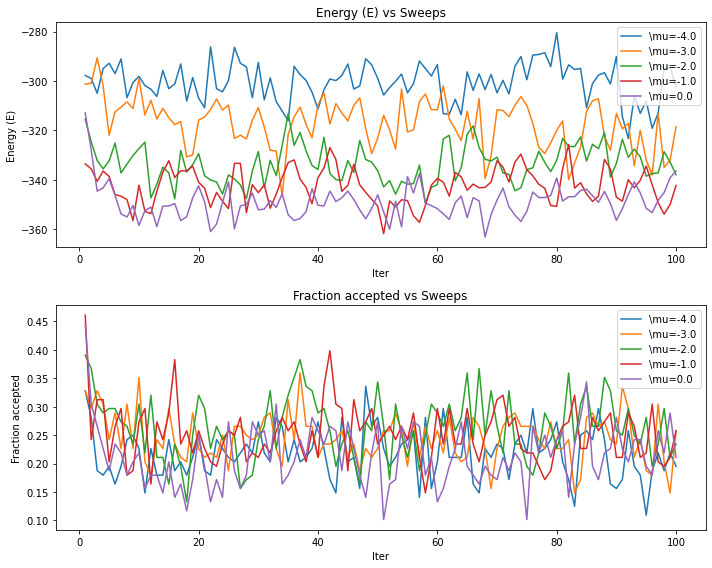

In [10]:
import matplotlib.pyplot as plt
# do the plots
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
runs = np.arange(1, num_runs+1)
legends = [f"\mu={mu}" for mu in chem_pots]
ax[0].plot(runs, all_energy_hist.T)
ax[0].set_xlabel("Iter")
ax[0].set_ylabel("Energy (E)")
ax[0].set_title("Energy (E) vs Sweeps")
ax[0].legend(legends)

ax[1].plot(runs, all_frac_accept_hist.T)
ax[1].set_xlabel("Iter")
ax[1].set_ylabel("Fraction accepted")
ax[1].set_title("Fraction accepted vs Sweeps")
ax[1].legend(legends)

fig.tight_layout()
fig.show()
# fig.savefig("energy_per_spin")
# fig.savefig("sgmc_anneal_alpha_0.9_repeat1.png")

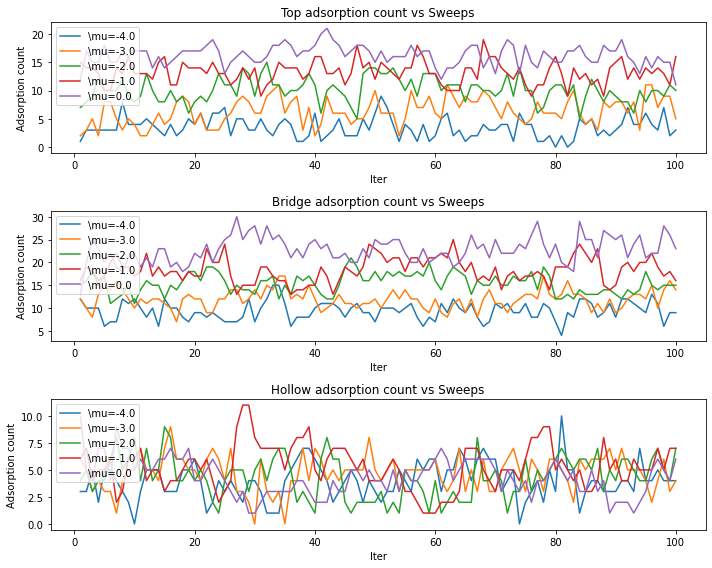

In [11]:
import matplotlib.pyplot as plt

# do the plots
fig, ax = plt.subplots(3, 1, figsize=(10, 8))
runs = np.arange(1, num_runs+1)
legends = [f"\mu={mu}" for mu in chem_pots]

ax[0].plot(runs, all_top_count_hist.T)
ax[0].set_xlabel("Iter")
ax[0].set_ylabel("Adsorption count")
ax[0].set_title("Top adsorption count vs Sweeps")
ax[0].legend(legends)

ax[1].plot(runs, all_bridge_count_hist.T)
ax[1].set_xlabel("Iter")
ax[1].set_ylabel("Adsorption count")
ax[1].set_title("Bridge adsorption count vs Sweeps")
ax[1].legend(legends)

ax[2].plot(runs, all_hollow_count_hist.T)
ax[2].set_xlabel("Iter")
ax[2].set_ylabel("Adsorption count")
ax[2].set_title("Hollow adsorption count vs Sweeps")
ax[2].legend(legends)

fig.show()
fig.tight_layout()

Fine grain work

In [23]:
from time import perf_counter

chem_pots = np.linspace(-4.0, -3.75, 10)
# chem_pots = [0] # do just one

# use LAMMPS
parameters = {
    'pair_style': 'eam',
    'pair_coeff': ['* * Au_u3.eam']
}

potential_file = os.path.join(os.environ["LAMMPS_POTENTIALS"], 'Au_u3.eam')
lammps_calc = LAMMPS(files=[potential_file], keep_tmp_files=False, keep_alive=False, tmp_dir="/home/dux/surface_sampling/tmp_files")
lammps_calc.set(**parameters)

# Au from standard cell
atoms = read('Au_mp-81_conventional_standard.cif')
slab, surface_atoms = surfaces.surface_from_bulk(atoms, [1,1,0], size=[4,4])
slab.write('Au_110_pristine_slab.cif')

slab.calc = lammps_calc

num_runs = 100
all_energy_hist = np.random.rand(len(chem_pots), num_runs)
all_frac_accept_hist = np.random.rand(len(chem_pots), num_runs)
all_top_count_hist = np.random.rand(len(chem_pots), num_runs)
all_bridge_count_hist = np.random.rand(len(chem_pots), num_runs)
all_hollow_count_hist = np.random.rand(len(chem_pots), num_runs)

element = 'Au'

for i, chem_pot in enumerate(chem_pots):
    start = perf_counter()
    # reset every 8 iter
    slab, surface_atoms = surfaces.surface_from_bulk(atoms, [1,1,0], size=[4,4])

    history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_runs=num_runs, temp=1, pot=chem_pot, alpha=0.98, slab=slab, calc=lammps_calc, element=element)
    stop = perf_counter()
    print(f"Time taken = {stop - start} seconds")
    all_energy_hist[i] = energy_hist
    all_frac_accept_hist[i] = frac_accept_hist
    all_top_count_hist[i] = adsorption_count_hist[1]
    all_bridge_count_hist[i] = adsorption_count_hist[2]
    all_hollow_count_hist[i] = adsorption_count_hist[4]

/home/dux/miniconda3/envs/mlenv/lib/python3.9/site-packages/catkit/gen/surface.py:334: UserWarning: Your slab has no bulk atoms and may be too thin to identify surface atoms correctly. This may cause surface adsorption site identification to fail.
  warnings.warn(
INFO:Running with num_runs = 100, temp = 1, pot = -4.0, alpha = 0.98
/home/dux/miniconda3/envs/mlenv/lib/python3.9/site-packages/catkit/gen/adsorption.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r1_topology = np.array(self.r1_topology)
/home/dux/miniconda3/envs/mlenv/lib/python3.9/site-packages/catkit/gen/adsorption.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f9b88165820>


INFO:In pristine slab, there are a total of 192 sites
/home/dux/miniconda3/envs/mlenv/lib/python3.9/site-packages/ase/calculators/lammpsrun.py:379: UserWarning: semi-periodic ASE cell detected - translation to proper LAMMPS input cell might fail
  warnings.warn(
INFO:running for 192 iterations per run over a total of 100 runs
INFO:In sweep 1 out of 100
INFO:In sweep 2 out of 100
INFO:In sweep 3 out of 100
INFO:In sweep 4 out of 100
INFO:In sweep 5 out of 100
INFO:In sweep 6 out of 100
INFO:In sweep 7 out of 100
INFO:In sweep 8 out of 100
INFO:In sweep 9 out of 100
INFO:In sweep 10 out of 100
INFO:In sweep 11 out of 100
INFO:In sweep 12 out of 100
INFO:In sweep 13 out of 100
INFO:In sweep 14 out of 100
INFO:In sweep 15 out of 100
INFO:In sweep 16 out of 100
INFO:In sweep 17 out of 100
INFO:In sweep 18 out of 100
INFO:In sweep 19 out of 100
INFO:In sweep 20 out of 100
INFO:In sweep 21 out of 100
INFO:In sweep 22 out of 100
INFO:In sweep 23 out of 100
INFO:In sweep 24 out of 100
INFO:In s

Time taken = 251.78863098472357 seconds


INFO:Running with num_runs = 100, temp = 1, pot = -3.9722222222222223, alpha = 0.98


using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f9b88165820>


INFO:In pristine slab, there are a total of 192 sites
INFO:running for 192 iterations per run over a total of 100 runs
INFO:In sweep 1 out of 100
INFO:In sweep 2 out of 100
INFO:In sweep 3 out of 100
INFO:In sweep 4 out of 100
INFO:In sweep 5 out of 100
INFO:In sweep 6 out of 100
INFO:In sweep 7 out of 100
INFO:In sweep 8 out of 100
INFO:In sweep 9 out of 100
INFO:In sweep 10 out of 100
INFO:In sweep 11 out of 100
INFO:In sweep 12 out of 100
INFO:In sweep 13 out of 100
INFO:In sweep 14 out of 100
INFO:In sweep 15 out of 100
INFO:In sweep 16 out of 100
INFO:In sweep 17 out of 100
INFO:In sweep 18 out of 100
INFO:In sweep 19 out of 100
INFO:In sweep 20 out of 100
INFO:In sweep 21 out of 100
INFO:In sweep 22 out of 100
INFO:In sweep 23 out of 100
INFO:In sweep 24 out of 100
INFO:In sweep 25 out of 100
INFO:In sweep 26 out of 100
INFO:In sweep 27 out of 100
INFO:In sweep 28 out of 100
INFO:In sweep 29 out of 100
INFO:In sweep 30 out of 100
INFO:In sweep 31 out of 100
INFO:In sweep 32 out o

Time taken = 249.44283860176802 seconds


INFO:Running with num_runs = 100, temp = 1, pot = -3.9444444444444446, alpha = 0.98


using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f9b88165820>


INFO:In pristine slab, there are a total of 192 sites
INFO:running for 192 iterations per run over a total of 100 runs
INFO:In sweep 1 out of 100
INFO:In sweep 2 out of 100
INFO:In sweep 3 out of 100
INFO:In sweep 4 out of 100
INFO:In sweep 5 out of 100
INFO:In sweep 6 out of 100
INFO:In sweep 7 out of 100
INFO:In sweep 8 out of 100
INFO:In sweep 9 out of 100
INFO:In sweep 10 out of 100
INFO:In sweep 11 out of 100
INFO:In sweep 12 out of 100
INFO:In sweep 13 out of 100
INFO:In sweep 14 out of 100
INFO:In sweep 15 out of 100
INFO:In sweep 16 out of 100
INFO:In sweep 17 out of 100
INFO:In sweep 18 out of 100
INFO:In sweep 19 out of 100
INFO:In sweep 20 out of 100
INFO:In sweep 21 out of 100
INFO:In sweep 22 out of 100
INFO:In sweep 23 out of 100
INFO:In sweep 24 out of 100
INFO:In sweep 25 out of 100
INFO:In sweep 26 out of 100
INFO:In sweep 27 out of 100
INFO:In sweep 28 out of 100
INFO:In sweep 29 out of 100
INFO:In sweep 30 out of 100
INFO:In sweep 31 out of 100
INFO:In sweep 32 out o

Time taken = 347.56754648685455 seconds


INFO:Running with num_runs = 100, temp = 1, pot = -3.9166666666666665, alpha = 0.98


using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f9b88165820>


INFO:In pristine slab, there are a total of 192 sites
INFO:running for 192 iterations per run over a total of 100 runs
INFO:In sweep 1 out of 100
INFO:In sweep 2 out of 100
INFO:In sweep 3 out of 100
INFO:In sweep 4 out of 100
INFO:In sweep 5 out of 100
INFO:In sweep 6 out of 100
INFO:In sweep 7 out of 100
INFO:In sweep 8 out of 100
INFO:In sweep 9 out of 100
INFO:In sweep 10 out of 100
INFO:In sweep 11 out of 100
INFO:In sweep 12 out of 100
INFO:In sweep 13 out of 100
INFO:In sweep 14 out of 100
INFO:In sweep 15 out of 100
INFO:In sweep 16 out of 100
INFO:In sweep 17 out of 100
INFO:In sweep 18 out of 100
INFO:In sweep 19 out of 100
INFO:In sweep 20 out of 100
INFO:In sweep 21 out of 100
INFO:In sweep 22 out of 100
INFO:In sweep 23 out of 100
INFO:In sweep 24 out of 100
INFO:In sweep 25 out of 100
INFO:In sweep 26 out of 100
INFO:In sweep 27 out of 100
INFO:In sweep 28 out of 100
INFO:In sweep 29 out of 100
INFO:In sweep 30 out of 100
INFO:In sweep 31 out of 100
INFO:In sweep 32 out o

Time taken = 384.42916913330555 seconds


INFO:Running with num_runs = 100, temp = 1, pot = -3.888888888888889, alpha = 0.98


using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f9b88165820>


INFO:In pristine slab, there are a total of 192 sites
INFO:running for 192 iterations per run over a total of 100 runs
INFO:In sweep 1 out of 100
INFO:In sweep 2 out of 100
INFO:In sweep 3 out of 100
INFO:In sweep 4 out of 100
INFO:In sweep 5 out of 100
INFO:In sweep 6 out of 100
INFO:In sweep 7 out of 100
INFO:In sweep 8 out of 100
INFO:In sweep 9 out of 100
INFO:In sweep 10 out of 100
INFO:In sweep 11 out of 100
INFO:In sweep 12 out of 100
INFO:In sweep 13 out of 100
INFO:In sweep 14 out of 100
INFO:In sweep 15 out of 100
INFO:In sweep 16 out of 100
INFO:In sweep 17 out of 100
INFO:In sweep 18 out of 100
INFO:In sweep 19 out of 100
INFO:In sweep 20 out of 100
INFO:In sweep 21 out of 100
INFO:In sweep 22 out of 100
INFO:In sweep 23 out of 100
INFO:In sweep 24 out of 100
INFO:In sweep 25 out of 100
INFO:In sweep 26 out of 100
INFO:In sweep 27 out of 100
INFO:In sweep 28 out of 100
INFO:In sweep 29 out of 100
INFO:In sweep 30 out of 100
INFO:In sweep 31 out of 100
INFO:In sweep 32 out o

Time taken = 292.34986739605665 seconds


INFO:Running with num_runs = 100, temp = 1, pot = -3.861111111111111, alpha = 0.98


using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f9b88165820>


INFO:In pristine slab, there are a total of 192 sites
INFO:running for 192 iterations per run over a total of 100 runs
INFO:In sweep 1 out of 100
INFO:In sweep 2 out of 100
INFO:In sweep 3 out of 100
INFO:In sweep 4 out of 100
INFO:In sweep 5 out of 100
INFO:In sweep 6 out of 100
INFO:In sweep 7 out of 100
INFO:In sweep 8 out of 100
INFO:In sweep 9 out of 100
INFO:In sweep 10 out of 100
INFO:In sweep 11 out of 100
INFO:In sweep 12 out of 100
INFO:In sweep 13 out of 100
INFO:In sweep 14 out of 100
INFO:In sweep 15 out of 100
INFO:In sweep 16 out of 100
INFO:In sweep 17 out of 100
INFO:In sweep 18 out of 100
INFO:In sweep 19 out of 100
INFO:In sweep 20 out of 100
INFO:In sweep 21 out of 100
INFO:In sweep 22 out of 100
INFO:In sweep 23 out of 100
INFO:In sweep 24 out of 100
INFO:In sweep 25 out of 100
INFO:In sweep 26 out of 100
INFO:In sweep 27 out of 100
INFO:In sweep 28 out of 100
INFO:In sweep 29 out of 100
INFO:In sweep 30 out of 100
INFO:In sweep 31 out of 100
INFO:In sweep 32 out o

Time taken = 248.51398096978664 seconds


INFO:Running with num_runs = 100, temp = 1, pot = -3.8333333333333335, alpha = 0.98


using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f9b88165820>


INFO:In pristine slab, there are a total of 192 sites
INFO:running for 192 iterations per run over a total of 100 runs
INFO:In sweep 1 out of 100
INFO:In sweep 2 out of 100
INFO:In sweep 3 out of 100
INFO:In sweep 4 out of 100
INFO:In sweep 5 out of 100
INFO:In sweep 6 out of 100
INFO:In sweep 7 out of 100
INFO:In sweep 8 out of 100
INFO:In sweep 9 out of 100
INFO:In sweep 10 out of 100
INFO:In sweep 11 out of 100
INFO:In sweep 12 out of 100
INFO:In sweep 13 out of 100
INFO:In sweep 14 out of 100
INFO:In sweep 15 out of 100
INFO:In sweep 16 out of 100
INFO:In sweep 17 out of 100
INFO:In sweep 18 out of 100
INFO:In sweep 19 out of 100
INFO:In sweep 20 out of 100
INFO:In sweep 21 out of 100
INFO:In sweep 22 out of 100
INFO:In sweep 23 out of 100
INFO:In sweep 24 out of 100
INFO:In sweep 25 out of 100
INFO:In sweep 26 out of 100
INFO:In sweep 27 out of 100
INFO:In sweep 28 out of 100
INFO:In sweep 29 out of 100
INFO:In sweep 30 out of 100
INFO:In sweep 31 out of 100
INFO:In sweep 32 out o

Time taken = 256.4304554462433 seconds


INFO:Running with num_runs = 100, temp = 1, pot = -3.8055555555555554, alpha = 0.98


using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f9b88165820>


INFO:In pristine slab, there are a total of 192 sites
INFO:running for 192 iterations per run over a total of 100 runs
INFO:In sweep 1 out of 100
INFO:In sweep 2 out of 100
INFO:In sweep 3 out of 100
INFO:In sweep 4 out of 100
INFO:In sweep 5 out of 100
INFO:In sweep 6 out of 100
INFO:In sweep 7 out of 100
INFO:In sweep 8 out of 100
INFO:In sweep 9 out of 100
INFO:In sweep 10 out of 100
INFO:In sweep 11 out of 100
INFO:In sweep 12 out of 100
INFO:In sweep 13 out of 100
INFO:In sweep 14 out of 100
INFO:In sweep 15 out of 100
INFO:In sweep 16 out of 100
INFO:In sweep 17 out of 100
INFO:In sweep 18 out of 100
INFO:In sweep 19 out of 100
INFO:In sweep 20 out of 100
INFO:In sweep 21 out of 100
INFO:In sweep 22 out of 100
INFO:In sweep 23 out of 100
INFO:In sweep 24 out of 100
INFO:In sweep 25 out of 100
INFO:In sweep 26 out of 100
INFO:In sweep 27 out of 100
INFO:In sweep 28 out of 100
INFO:In sweep 29 out of 100
INFO:In sweep 30 out of 100
INFO:In sweep 31 out of 100
INFO:In sweep 32 out o

Time taken = 255.38466969877481 seconds


INFO:Running with num_runs = 100, temp = 1, pot = -3.7777777777777777, alpha = 0.98


using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f9b88165820>


INFO:In pristine slab, there are a total of 192 sites
INFO:running for 192 iterations per run over a total of 100 runs
INFO:In sweep 1 out of 100
INFO:In sweep 2 out of 100
INFO:In sweep 3 out of 100
INFO:In sweep 4 out of 100
INFO:In sweep 5 out of 100
INFO:In sweep 6 out of 100
INFO:In sweep 7 out of 100
INFO:In sweep 8 out of 100
INFO:In sweep 9 out of 100
INFO:In sweep 10 out of 100
INFO:In sweep 11 out of 100
INFO:In sweep 12 out of 100
INFO:In sweep 13 out of 100
INFO:In sweep 14 out of 100
INFO:In sweep 15 out of 100
INFO:In sweep 16 out of 100
INFO:In sweep 17 out of 100
INFO:In sweep 18 out of 100
INFO:In sweep 19 out of 100
INFO:In sweep 20 out of 100
INFO:In sweep 21 out of 100
INFO:In sweep 22 out of 100
INFO:In sweep 23 out of 100
INFO:In sweep 24 out of 100
INFO:In sweep 25 out of 100
INFO:In sweep 26 out of 100
INFO:In sweep 27 out of 100
INFO:In sweep 28 out of 100
INFO:In sweep 29 out of 100
INFO:In sweep 30 out of 100
INFO:In sweep 31 out of 100
INFO:In sweep 32 out o

Time taken = 256.46831335127354 seconds


INFO:Running with num_runs = 100, temp = 1, pot = -3.75, alpha = 0.98


using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f9b88165820>


INFO:In pristine slab, there are a total of 192 sites
INFO:running for 192 iterations per run over a total of 100 runs
INFO:In sweep 1 out of 100
INFO:In sweep 2 out of 100
INFO:In sweep 3 out of 100
INFO:In sweep 4 out of 100
INFO:In sweep 5 out of 100
INFO:In sweep 6 out of 100
INFO:In sweep 7 out of 100
INFO:In sweep 8 out of 100
INFO:In sweep 9 out of 100
INFO:In sweep 10 out of 100
INFO:In sweep 11 out of 100
INFO:In sweep 12 out of 100
INFO:In sweep 13 out of 100
INFO:In sweep 14 out of 100
INFO:In sweep 15 out of 100
INFO:In sweep 16 out of 100
INFO:In sweep 17 out of 100
INFO:In sweep 18 out of 100
INFO:In sweep 19 out of 100
INFO:In sweep 20 out of 100
INFO:In sweep 21 out of 100
INFO:In sweep 22 out of 100
INFO:In sweep 23 out of 100
INFO:In sweep 24 out of 100
INFO:In sweep 25 out of 100
INFO:In sweep 26 out of 100
INFO:In sweep 27 out of 100
INFO:In sweep 28 out of 100
INFO:In sweep 29 out of 100
INFO:In sweep 30 out of 100
INFO:In sweep 31 out of 100
INFO:In sweep 32 out o

Time taken = 254.23751682043076 seconds


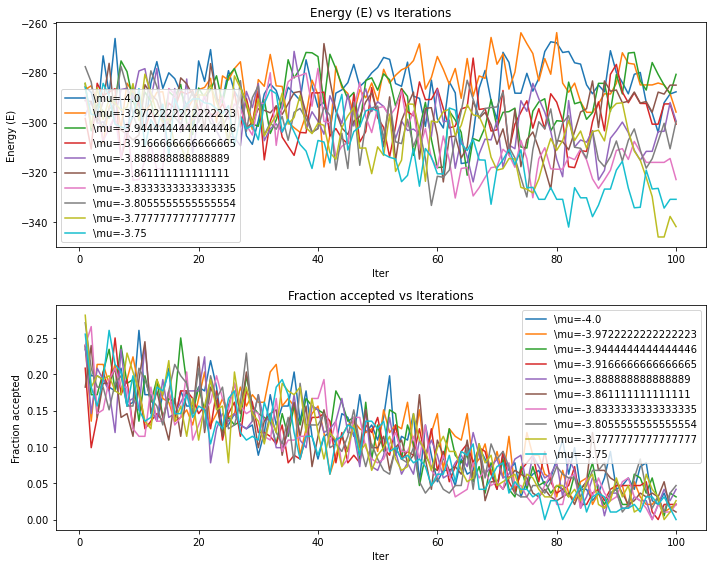

In [24]:
import matplotlib.pyplot as plt
# do the plots
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
runs = np.arange(1, num_runs+1)
legends = [f"\mu={mu}" for mu in chem_pots]
ax[0].plot(runs, all_energy_hist.T)
ax[0].set_xlabel("Iter")
ax[0].set_ylabel("Energy (E)")
ax[0].set_title("Energy (E) vs Iterations")
ax[0].legend(legends)

ax[1].plot(runs, all_frac_accept_hist.T)
ax[1].set_xlabel("Iter")
ax[1].set_ylabel("Fraction accepted")
ax[1].set_title("Fraction accepted vs Iterations")
ax[1].legend(legends)

fig.show()
fig.tight_layout()
# fig.savefig("energy_per_spin")
# fig.savefig("sgmc_anneal_alpha_0.9_repeat1.png")

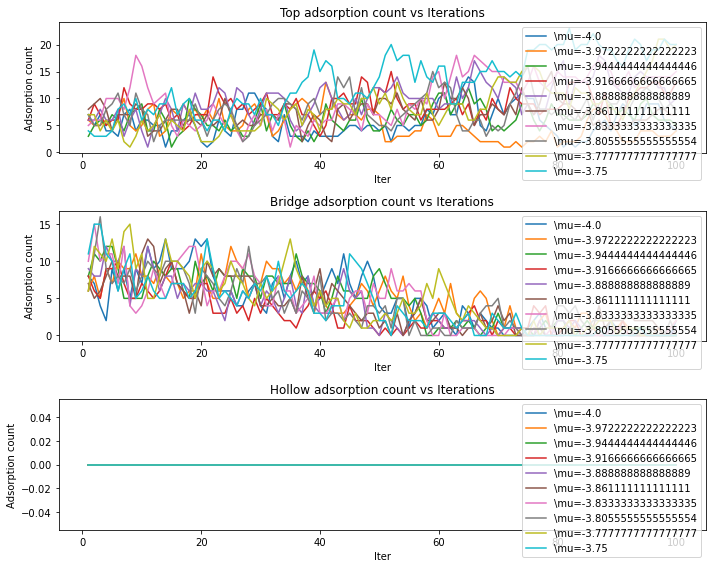

In [25]:
import matplotlib.pyplot as plt

# do the plots
fig, ax = plt.subplots(3, 1, figsize=(10, 8))
runs = np.arange(1, num_runs+1)
legends = [f"\mu={mu}" for mu in chem_pots]

ax[0].plot(runs, all_top_count_hist.T)
ax[0].set_xlabel("Iter")
ax[0].set_ylabel("Adsorption count")
ax[0].set_title("Top adsorption count vs Iterations")
ax[0].legend(legends)

ax[1].plot(runs, all_bridge_count_hist.T)
ax[1].set_xlabel("Iter")
ax[1].set_ylabel("Adsorption count")
ax[1].set_title("Bridge adsorption count vs Iterations")
ax[1].legend(legends)

ax[2].plot(runs, all_hollow_count_hist.T)
ax[2].set_xlabel("Iter")
ax[2].set_ylabel("Adsorption count")
ax[2].set_title("Hollow adsorption count vs Iterations")
ax[2].legend(legends)

fig.show()
fig.tight_layout()